# Clasificacion de imagenes con CNN con transfer learning


## Import of libraries and access to Drive unit



Importing the necessary libraries and modules required for data processing, model training, and evaluation within this image classification pipeline.


In [ ]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.image as mpimg
import seaborn as sns
import random
import zipfile
import pathlib
import csv

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential
import datetime
from tensorflow.keras.applications import EfficientNetB0, ResNet50V2, VGG16
from tensorflow.keras.preprocessing import image
from keras.models import load_model
from tensorflow import keras

from sklearn.metrics import confusion_matrix


As the model training is conducted on Google Colab, it is essential to request access to Google Drive to load the training dataset stored there.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Carga de DataSet



### Lectura Dataset

Navigating to the dataset folder to verify the number of images available in each subdirectory, ensuring balanced data distribution across categories.


In [ ]:
for dirpath,dirname,filename in os.walk("/content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification"):
  print(f'There are {len(dirname)} directories and {len(filename)} images in {dirpath}')

There are 5 directories and 1 images in /content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification
There are 5 directories and 0 images in /content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification/valid
There are 0 directories and 40 images in /content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification/valid/Strawberry
There are 0 directories and 40 images in /content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification/valid/Mango
There are 0 directories and 40 images in /content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification/valid/Apple
There are 0 directories and 40 images in /content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification/valid/Banana
There are 0 directories and 40 images in /content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification/valid/Grape
There are 5 directories and 0 images in /content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification/train
There are 0 directories and 1940 images in /content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classificat

Generating a vector containing the classification labels present in the dataset, which will be used to map each image to its corresponding category.


In [ ]:
data_dir= pathlib.Path("/content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification/train")
class_names = [i.name for i in data_dir.glob('*')]
class_names

['Mango', 'Banana', 'Grape', 'Apple', 'Strawberry']

### Function to view images

Defining a function to efficiently organize and visualize images, facilitating quick inspection and verification of dataset samples.

In [ ]:
def view_random_image(target_dir,target_class):
  #setup target directory
  target_folder = target_dir+"/"+target_class
  # print(target_folder)
  #get the random image from the target dir and targetclass
  random_image = random.sample(os.listdir(target_folder),1)
  print(random_image[0])

  #read the image and plot
  img = mpimg.imread(target_folder+"/"+random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off')

  print(f'Image shape:{img.shape}')

  return img

Apple (14).png
Image shape:(222, 227, 4)


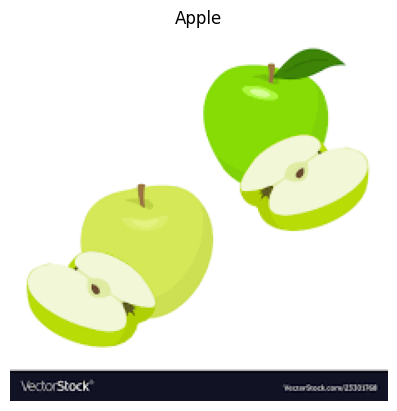

In [ ]:
img =view_random_image(target_dir="/content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification/train",target_class='Apple')

### Data Preprocessing and Augmentation Setup for Image Classification


Configuring data generators with specified image dimensions and batch size. Using ImageDataGenerator to normalize pixel values and load images from training and validation directories with categorical labels for multi-class classification.

In [ ]:
Image_shape=(224,224)
Batch_size=32

train_dir='/content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification/train/'
val_dir='/content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification/valid/'

train_data_gen = ImageDataGenerator(rescale=1/255)
val_data_gen = ImageDataGenerator(rescale=1/255)

train_data = train_data_gen.flow_from_directory(train_dir,target_size=Image_shape,
                                                        batch_size=Batch_size,
                                                        class_mode='categorical')

valid_data = val_data_gen.flow_from_directory(val_dir,
                                              target_size=Image_shape,
                                              batch_size=Batch_size,
                                              class_mode='categorical')

Found 9700 images belonging to 5 classes.
Found 200 images belonging to 5 classes.


### Creating a TensorBoard Callback for Model Training Visualization


Defining a function to create a TensorBoard callback, which logs training metrics to a specified directory. The log directory is structured to include the experiment name and a timestamp for organized tracking of model performance over time.

In [ ]:
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir=dir_name+'/'+experiment_name+'/'+datetime.datetime.now().strftime('%Y%m%d-%H')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'saving tensorboardcallback:{log_dir}')
  return tensorboard_callback

## Model ResNetV50


### Architecture statement

In [ ]:
base_model = ResNet50V2(include_top=False)

base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224,224,3),name='input_layer')

x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)# resnet model does not have the the normalized layers
x = base_model(inputs)

print(f'Shape after base_model:{x.shape}')

x = tf.keras.layers.GlobalAveragePooling2D(name='gloabl_average2D')(x)
print(f'Global average 2D pooling shape:{x.shape}')

outputs = tf.keras.layers.Dense(5,activation='softmax',name='output_layer')(x)

model_ResNetv50=tf.keras.Model(inputs,outputs)

model_ResNetv50.compile(loss='categorical_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])
model_ResNetv50.summary()

Shape after base_model:(None, 7, 7, 2048)
Global average 2D pooling shape:(None, 2048)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 gloabl_average2D (GlobalAve  (None, 2048)             0         
 ragePooling2D)                                                  
                                                                 
 output_layer (Dense)        (None, 5)                 10245     
                                                                 
Total params: 23,575,045
Trainable params: 10,245
Non-trainable params: 23,564,800
_________________________________________________________________


### Training

In [ ]:
history_transferlearning_ResNetv50= model_ResNetv50.fit(train_data,
                                        epochs=20,
                                        steps_per_epoch=len(train_data),
                                        validation_data=valid_data,
                                        validation_steps=int(0.25*len(valid_data)),
                                        callbacks=[])

Epoch 1/20
304/304 [==============================] - 4819s 16s/step - loss: 0.5694 - accuracy: 0.7949 - val_loss: 0.2822 - val_accuracy: 0.9375
Epoch 2/20
304/304 [==============================] - 59s 194ms/step - loss: 0.3633 - accuracy: 0.8712 - val_loss: 0.4555 - val_accuracy: 0.8125
Epoch 3/20
304/304 [==============================] - 54s 176ms/step - loss: 0.3049 - accuracy: 0.8935 - val_loss: 0.5211 - val_accuracy: 0.7812
Epoch 4/20
304/304 [==============================] - 51s 168ms/step - loss: 0.2694 - accuracy: 0.9081 - val_loss: 0.5379 - val_accuracy: 0.7500
Epoch 5/20
304/304 [==============================] - 42s 137ms/step - loss: 0.2394 - accuracy: 0.9175 - val_loss: 0.4510 - val_accuracy: 0.8125
Epoch 6/20
304/304 [==============================] - 44s 144ms/step - loss: 0.2170 - accuracy: 0.9268 - val_loss: 0.3424 - val_accuracy: 0.8750
Epoch 7/20
304/304 [==============================] - 41s 133ms/step - loss: 0.2017 - accuracy: 0.9351 - val_loss: 0.3889 - val_ac

### Save the model

In [ ]:
model_ResNetv50.save("/content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification/Models/2/model_ResNet50V2.h5")

with open('/content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification/Models/2/history_transferlearning_ResNetv50.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(history_transferlearning_ResNetv50.history.keys())
    writer.writerows(zip(*history_transferlearning_ResNetv50.history.values()))

## CNN without TransferLearning

### Architecture statement

In [ ]:
#Creación de modelo

model_zero = Sequential()

inputShape = (224, 224, 3)
model_zero.add(Conv2D(32,(3,3), input_shape=inputShape))
model_zero.add(Conv2D(32,(3,3)))
model_zero.add(MaxPool2D())

model_zero.add(Conv2D(64,(3,3)))
model_zero.add(Conv2D(64,(3,3)))
model_zero.add(Conv2D(64,(3,3)))
model_zero.add(MaxPool2D())

model_zero.add(Flatten())
model_zero.add(Dense(64,activation='relu'))
model_zero.add(Dense(32,activation='relu'))
model_zero.add(Dense(5,activation='softmax', name='output'))


model_zero.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])
model_zero.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 conv2d_6 (Conv2D)           (None, 220, 220, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 110, 110, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 108, 108, 64)      18496     
                                                                 
 conv2d_8 (Conv2D)           (None, 106, 106, 64)      36928     
                                                                 
 conv2d_9 (Conv2D)           (None, 104, 104, 64)      36928     
                                                      

### Training

In [ ]:
history_CNN= model_zero.fit(train_data,
                                        epochs=50,
                                        steps_per_epoch=len(train_data),
                                        validation_data=valid_data,
                                        validation_steps=int(0.25*len(valid_data)),
                                        callbacks=[create_tensorboard_callback("transfer_learning",'transfer_learning_featureextraction')])

saving tensorboardcallback:transfer_learning/transfer_learning_featureextraction/20230629-01
Epoch 1/50
304/304 [==============================] - 49s 136ms/step - loss: 1.5242 - accuracy: 0.3454 - val_loss: 1.4218 - val_accuracy: 0.4688
Epoch 2/50
304/304 [==============================] - 40s 132ms/step - loss: 1.3954 - accuracy: 0.4215 - val_loss: 1.3644 - val_accuracy: 0.5000
Epoch 3/50
304/304 [==============================] - 39s 127ms/step - loss: 1.3434 - accuracy: 0.4374 - val_loss: 1.6317 - val_accuracy: 0.3125
Epoch 4/50
304/304 [==============================] - 39s 127ms/step - loss: 1.3148 - accuracy: 0.4457 - val_loss: 1.3656 - val_accuracy: 0.5000
Epoch 5/50
304/304 [==============================] - 41s 134ms/step - loss: 1.2962 - accuracy: 0.4509 - val_loss: 1.3212 - val_accuracy: 0.4375
Epoch 6/50
304/304 [==============================] - 39s 127ms/step - loss: 1.2802 - accuracy: 0.4566 - val_loss: 1.3292 - val_accuracy: 0.3750
Epoch 7/50
304/304 [=================

### Save the model

In [ ]:
model_zero.save("/content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification/Models/model_zero.h5")

with open('/content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification/Models/historial_zero.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(history_CNN.history.keys())
    writer.writerows(zip(*history_CNN.history.values()))

## VGG16

### Architecture statement

In [ ]:
base_model_VGG16 = VGG16(include_top=False)

base_model_VGG16.trainable = False

inputs = tf.keras.layers.Input(shape=(224,224,3),name='input_layer')

x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)# resnet model does not have the the normalized layers
x = base_model_VGG16(inputs)

x = tf.keras.layers.GlobalAveragePooling2D(name='gloabl_average2D')(x)

outputs = tf.keras.layers.Dense(5,activation='softmax',name='output_layer')(x)

model_VGG16=tf.keras.Model(inputs,outputs)

model_VGG16.compile(loss='categorical_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])
model_VGG16.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 gloabl_average2D (GlobalAve  (None, 512)              0         
 ragePooling2D)                                                  
                                                                 
 output_layer (Dense)        (None, 5)                 2565      
                                                                 
Total params: 14,717,253
Trainable params: 2,565
Non-trainable params: 14,714,688
_________________________________________________________________


### Training

In [ ]:
history_transferlearning_VGG16= model_VGG16.fit(train_data,
                                        epochs=20,
                                        steps_per_epoch=len(train_data),
                                        validation_data=valid_data,
                                        validation_steps=int(0.25*len(valid_data)),
                                        callbacks=[])

Epoch 1/20
304/304 [==============================] - 1941s 6s/step - loss: 1.2910 - accuracy: 0.5404 - val_loss: 1.0883 - val_accuracy: 0.6875
Epoch 2/20
304/304 [==============================] - 52s 171ms/step - loss: 1.0144 - accuracy: 0.6602 - val_loss: 1.0045 - val_accuracy: 0.5625
Epoch 3/20
304/304 [==============================] - 48s 157ms/step - loss: 0.9087 - accuracy: 0.6889 - val_loss: 1.0089 - val_accuracy: 0.5625
Epoch 4/20
304/304 [==============================] - 46s 152ms/step - loss: 0.8494 - accuracy: 0.7104 - val_loss: 0.7837 - val_accuracy: 0.6875
Epoch 5/20
304/304 [==============================] - 45s 147ms/step - loss: 0.8080 - accuracy: 0.7223 - val_loss: 0.7438 - val_accuracy: 0.7500
Epoch 6/20
304/304 [==============================] - 44s 143ms/step - loss: 0.7793 - accuracy: 0.7330 - val_loss: 0.6443 - val_accuracy: 0.8750
Epoch 7/20
304/304 [==============================] - 44s 143ms/step - loss: 0.7540 - accuracy: 0.7404 - val_loss: 0.7503 - val_acc

### Save Model

In [ ]:
model_VGG16.save("/content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification/Models/VGG16/model_VGG16.h5")

with open('/content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification/Models/VGG16/historial_VGG16.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(history_transferlearning_VGG16.history.keys())
    writer.writerows(zip(*history_transferlearning_VGG16.history.values()))

##VGG16 Without TransferLearning

### Architecture statement

In [ ]:
base_model_VGG16 = VGG16(include_top=False)

base_model_VGG16.trainable = True

inputs = tf.keras.layers.Input(shape=(224,224,3),name='input_layer')

x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)# resnet model does not have the the normalized layers
x = base_model_VGG16(inputs)

x = tf.keras.layers.GlobalAveragePooling2D(name='gloabl_average2D')(x)

outputs = tf.keras.layers.Dense(5,activation='softmax',name='output_layer')(x)

model_VGG16_zero=tf.keras.Model(inputs,outputs)

model_VGG16_zero.compile(loss='categorical_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])
model_VGG16_zero.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 gloabl_average2D (GlobalAve  (None, 512)              0         
 ragePooling2D)                                                  
                                                                 
 output_layer (Dense)        (None, 5)                 2565      
                                                                 
Total params: 14,717,253
Trainable params: 14,717,253
Non-trainable params: 0
_________________________________________________________________


### Training

In [ ]:
history_VGG16_zero= model_VGG16_zero.fit(train_data,
                                        epochs=50,
                                        steps_per_epoch=len(train_data),
                                        validation_data=valid_data,
                                        validation_steps=int(0.25*len(valid_data)),
                                        callbacks=[create_tensorboard_callback("transfer_learning",'transfer_learning_featureextraction')])

saving tensorboardcallback:transfer_learning/transfer_learning_featureextraction/20230629-03
Epoch 1/50
304/304 [==============================] - 119s 379ms/step - loss: 1.7819 - accuracy: 0.2045 - val_loss: 1.6110 - val_accuracy: 0.1875
Epoch 2/50
304/304 [==============================] - 113s 371ms/step - loss: 1.6097 - accuracy: 0.1942 - val_loss: 1.6105 - val_accuracy: 0.1562
Epoch 3/50
304/304 [==============================] - 112s 369ms/step - loss: 1.6096 - accuracy: 0.1987 - val_loss: 1.6072 - val_accuracy: 0.3125
Epoch 4/50
304/304 [==============================] - 112s 368ms/step - loss: 1.6096 - accuracy: 0.1946 - val_loss: 1.6097 - val_accuracy: 0.1250
Epoch 5/50
304/304 [==============================] - 112s 369ms/step - loss: 1.6096 - accuracy: 0.1956 - val_loss: 1.6091 - val_accuracy: 0.1562
Epoch 6/50
304/304 [==============================] - 112s 369ms/step - loss: 1.6096 - accuracy: 0.1902 - val_loss: 1.6093 - val_accuracy: 0.2188
Epoch 7/50
304/304 [===========

### Save the Model

In [ ]:
model_VGG16_zero.save("/content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification/Models/model_VGG16_zero.h5")

with open('/content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification/Models/historial_VGG16_zero.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(history_VGG16_zero.history.keys())
    writer.writerows(zip(*history_VGG16_zero.history.values()))

# Results

### Visualization of results

In [ ]:
def plot_loss_curves(history,modelo):
  loss=history.history['loss']
  val_loss=history.history['val_loss']

  accuracy=history.history['accuracy']
  val_accuracy=history.history['val_accuracy']

  epochs= range(len(history.history['loss']))

  #plotloss
  plt.plot(epochs,loss,label='Training_loss')
  plt.plot(epochs,val_loss,label='Val_loss')
  plt.title('Loss '+modelo)
  plt.xlabel('Epocas')
  plt.legend()
  plt.savefig('/content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification/Models/Loss_'+modelo+'.png')

  #plotaccuracy
  plt.figure()
  plt.plot(epochs,accuracy,label='Training_accuracy')
  plt.plot(epochs,val_accuracy,label='Val_accuracy')
  plt.title('Accuracy '+modelo)
  plt.xlabel('Epocas')
  plt.legend()
  plt.savefig('/content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification/Models/Accurracy_'+modelo+'.png')
  print('/content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification/Models/Accurracy_'+modelo+'.png')
  # find indices of train_data
train_data.class_indices

## Some results

/content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification/Models/Accurracy_ResNetv50.png


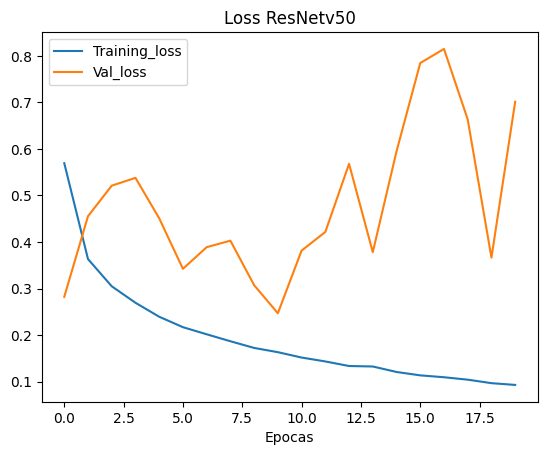

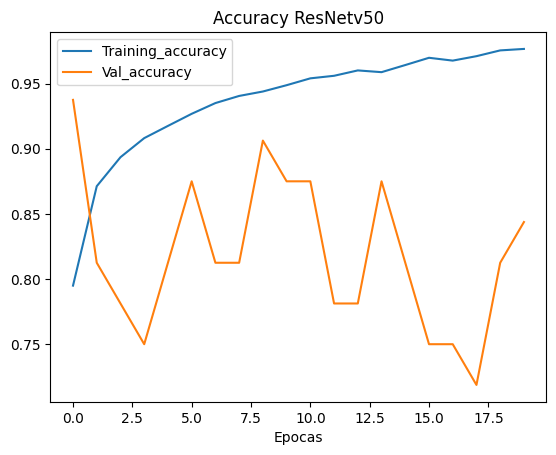

In [ ]:
plot_loss_curves(history_transferlearning_ResNetv50,'ResNetv50')

/content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification/Models/Accurracy_VGG16.png


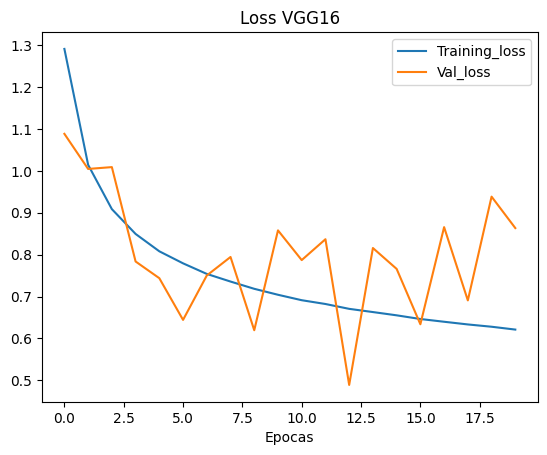

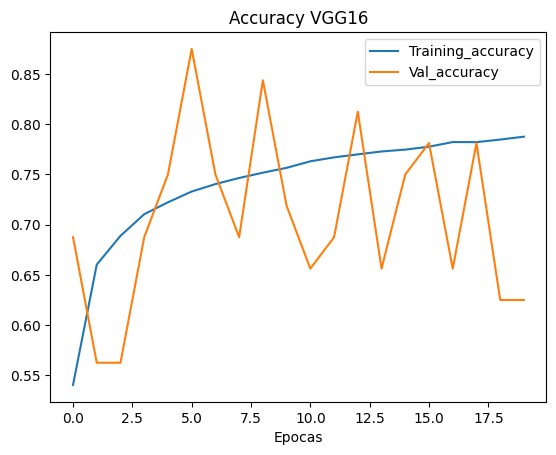

In [ ]:
plot_loss_curves(history_transferlearning_VGG16,'VGG16')

/content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification/Models/Accurracy_VGG16_zero.png


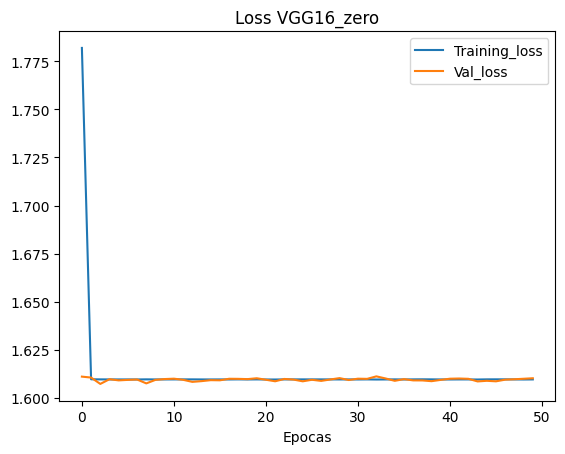

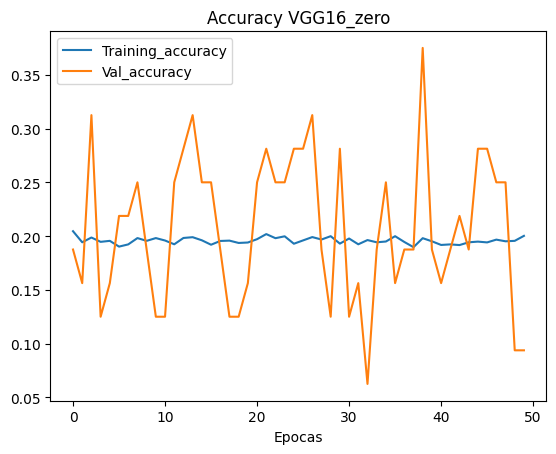

In [ ]:
plot_loss_curves(history_VGG16_zero,'VGG16_zero')

## Model predictions

### Prediction function

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing import image

dir_image=['/content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification/test/Apple/Apple (1729).jpeg',
           '/content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification/test/Banana/Banana (3362).jpeg',
'/content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification/test/Strawberry/Strawberry (1721).jpeg',
           '/content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification/test/Mango/Mango (1477).jpeg',
           '/content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification/test/Grape/Grape (1073).jpeg']

category = {
    0:'Manzana',
    1:'Banana',
    2:'Uva',
    3:'Mango',
    4:'Fresa'}

def preddiction(model):
    fig, axs = plt.subplots(1, 5, figsize=(10, 40))

    for i, img_path in enumerate(dir_image):
        img_ = image.load_img(img_path, target_size=(224, 224))
        axs[i].imshow(img_)
        img_array = image.img_to_array(img_)
        img_processed = img_array / 255.0  # Normalizar los valores de píxeles
        img_processed = np.expand_dims(img_processed, axis=0)

        new_model = keras.models.load_model(model)

        prediction = new_model.predict(img_processed)
        print(prediction)
        index = np.argmax(prediction)

        axs[i].set_title("Prediction - {}".format(category[index]))

    plt.tight_layout()
    plt.show()


### Some Results

VGG16
1/1 [==============================] - 8s 8s/step
[[0.5903301  0.0081878  0.1523035  0.24696358 0.002215  ]]
1/1 [==============================] - 0s 126ms/step
[[0.01189581 0.93743324 0.00849179 0.0331942  0.00898506]]
1/1 [==============================] - 0s 130ms/step
[[0.03609999 0.01297484 0.06438196 0.0270706  0.8594726 ]]
1/1 [==============================] - 0s 123ms/step
[[0.05211176 0.01791985 0.01806352 0.8907364  0.02116849]]


1/1 [==============================] - 0s 129ms/step
[[7.6016673e-04 2.4491968e-04 9.8575413e-01 6.0228918e-05 1.3180548e-02]]


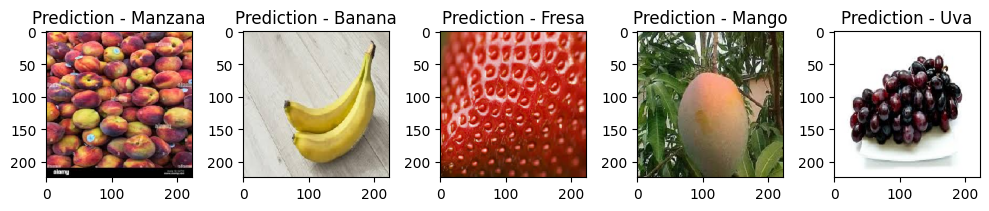

ResNet


1/1 [==============================] - 1s 1s/step
[[8.4533882e-01 5.7450066e-05 6.0244772e-04 1.5390469e-01 9.6591823e-05]]
1/1 [==============================] - 1s 822ms/step
[[1.4168512e-10 1.0000000e+00 2.4880830e-11 8.1208732e-13 4.6331146e-16]]
1/1 [==============================] - 1s 1s/step
[[1.9611669e-05 3.5162720e-06 1.8300136e-06 5.4683737e-06 9.9996960e-01]]
1/1 [==============================] - 1s 771ms/step
[[2.56040972e-02 1.51056865e-05 6.10680727e-04 9.73770142e-01
  1.53588642e-09]]
1/1 [==============================] - 1s 758ms/step
[[2.1417684e-07 2.4488422e-09 9.9999964e-01 1.3988216e-11 1.5220313e-07]]


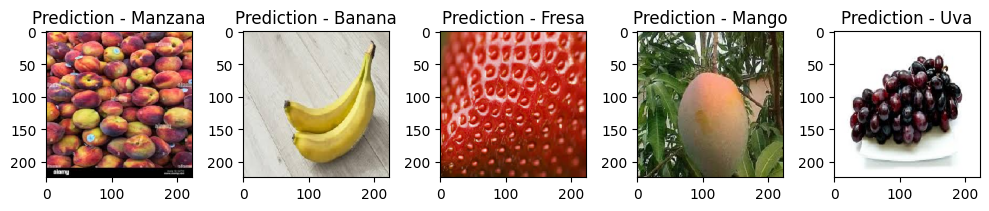

CNN
1/1 [==============================] - 0s 347ms/step
[[0.42713502 0.08510236 0.09391496 0.0722126  0.321635  ]]
1/1 [==============================] - 0s 79ms/step
[[0.09170564 0.6702521  0.03876182 0.19501135 0.00426904]]
1/1 [==============================] - 0s 128ms/step
[[0.163      0.00341945 0.01340427 0.00279127 0.817385  ]]
1/1 [==============================] - 0s 134ms/step
[[0.05302132 0.04265259 0.00605634 0.7618265  0.13644323]]
1/1 [==============================] - 0s 130ms/step
[[1.7248526e-02 2.3893905e-03 9.1821051e-01 5.7062646e-04 6.1580926e-02]]


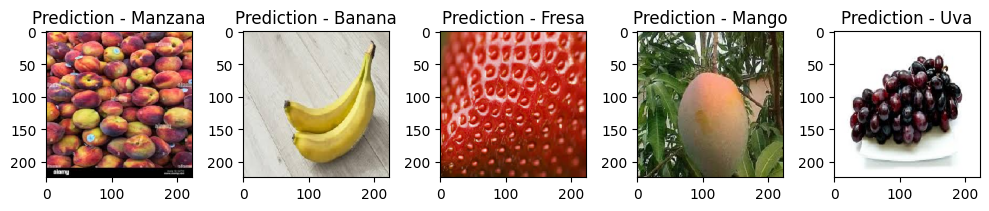

In [ ]:
print("VGG16")
modelo = "/content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification/Models/VGG16/model_VGG16.h5"
preddiction(modelo)
print("ResNet")
modelo = "/content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification/Models/ResNet50/model_ResNet50V2.h5"
preddiction(modelo)
print("CNN")
modelo = "/content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification/Models/Zero/model_zero.h5"
preddiction(modelo)

### Test folder prediction

In [ ]:
def predict_dir(filedir,model):
  cols=3
  pos=0
  images=[]
  total_images=len(os.listdir(filedir))
  rows=(total_images//cols+1)
  true = filedir.split('/')[-1]

  for i in sorted(os.listdir(filedir)):
    images.append(os.path.join(filedir,i))

  for subplot,imgg in enumerate(images):
    img_ = image.load_img(imgg,target_size=(224,224))
    img_array = image.img_to_array(img_)

    img_processed = np.expand_dims(img_array,axis=0)
    img_processed /= 255

    prediction = model.predict(img_processed)
    index = np.argmax(prediction)

    pred = category.get(index)
    if pred==true:
      pos+=1
  accu = pos/total_images
  print("Accuracy for {orignal}: {:.2f} ({pos}/{total})".format(accu,pos=pos,total=total_images,orignal=true))

## Functions of the confusion matrix

In [ ]:
from tensorflow.keras.preprocessing import image

def labels_confusion_matix(folder,model):
  mapping ={}
  new_model = keras.models.load_model(model)
  for i,j in enumerate(sorted(os.listdir(folder))):
    # print(i)
    # print(j)

    mapping[j]=i
  files=[]
  real=[]
  predicted=[]

  for i in os.listdir(folder):
    true = os.path.join(folder,i)
    true = true.split('/')[-1]
    # print(true)
    true = (mapping[true])

    for j in os.listdir(os.path.join(folder,i)):
      img_ = image.load_img(os.path.join(folder,i,j), target_size=(224,224))
      img_array = image.img_to_array(img_)

      img_processed = np.expand_dims(img_array,axis=0)
      img_processed /=255

      prediction = new_model.predict(img_processed)

      index = np.argmax(prediction)

      predicted.append(index)
      real.append(true)
  return real,predicted

In [ ]:

def print_confusion_matrix(real,predicted):
  total_output_labels=5
  cmap='turbo'

  cm_plot_labels=[i for i in range(5)]

  cm = confusion_matrix(y_true=real,y_pred=predicted)

  df_cm = pd.DataFrame(cm,cm_plot_labels,cm_plot_labels)

  sns.set(font_scale=1.2)

  plt.figure(figsize=(15,10))

  s=sns.heatmap(df_cm,fmt="d", annot=True,cmap=cmap)

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.savefig('confusion_matrix.png')
  plt.title('Matriz de confusión para CNN')
  plt.show()

### Some Results

1/1 [==============================] - 0s 20ms/step


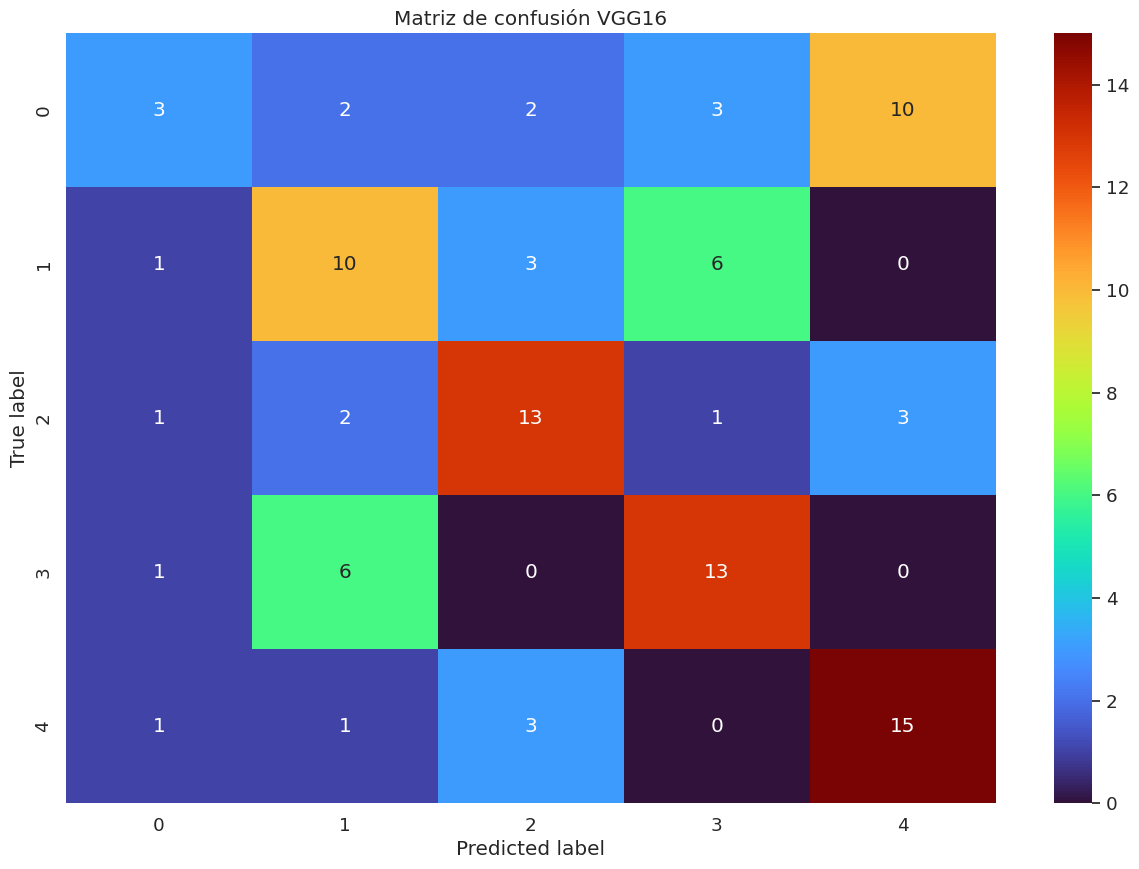

In [ ]:
y_true,y_pred=labels_confusion_matix('/content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification/test',
                                    '/content/drive/MyDrive/DataSet/Clas_Ima/Fruits Classification/Models/Zero/model_zero.h5')
print_confusion_matrix(y_true,y_pred)

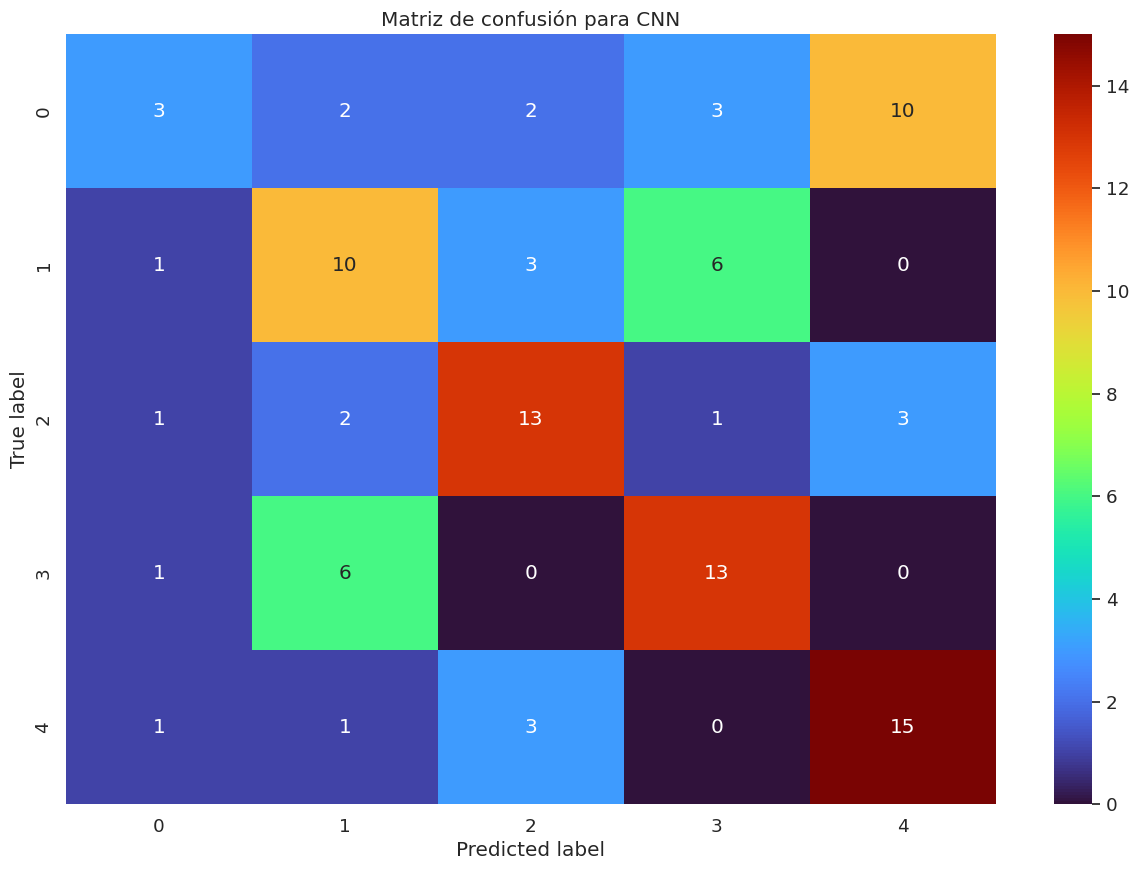

In [ ]:
print_confusion_matrix(y_true,y_pred)